In [2]:
import os
import numpy as np
from collections import Counter
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import re
import pandas as pd

In [3]:
# Data Preprocessing
def preprocessing(text):
    s = str(text)
    s = s.lower()
    s = s.replace('\n', ' ')
    s = s.replace('\r', ' ')
    s = re.sub(r'[^a-zA-Z0-9\s]', ' ', s)
    tokens = [token for token in s.split(" ") if token != ""]

    # Stopwords checking
    T = [t for t in tokens]
    return ' '.join(T)

In [4]:
# Dataset load (CSV)
dataset_path = './dataset/adult.csv'
df = pd.read_csv(dataset_path, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
# Renaming column
col_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship',
             'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']
df.columns = col_names
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income'],
      dtype='object')

In [6]:
# Previewing dataset again
df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [7]:
# View summary of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [8]:
# Find the categorical (qualitative) variables
categorical = [var for var in df.columns if df[var].dtype == 'O']

print('There are {} categorical variables\n'.format(len(categorical)))
print('The categorical variables are :\n\n', categorical)

There are 9 categorical variables

The categorical variables are :

 ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country', 'income']


In [9]:
# View the categorical variables
df[categorical].head()

,workclass,education,marital_status,occupation,relationship,race,sex,native_country,income
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K


In [10]:
df.workclass.unique()
df.workclass.value_counts()

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64

In [11]:
# replace '?' values in workclass variable with `NaN`
df['workclass'].replace(' ?', np.NaN, inplace=True)
df.workclass.value_counts()

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64

In [12]:
# Replace '?' values in occupation variable with `NaN`
df['occupation'].replace(' ?', np.NaN, inplace=True)
df.occupation.value_counts()

 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3770
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name: occupation, dtype: int64

In [13]:
# Replace '?' values in native_country variable with `NaN`
df['native_country'].replace(' ?', np.NaN, inplace=True)
df.native_country.value_counts()

 United-States                 29170
 Mexico                          643
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Guatemala                        64
 Japan                            62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                             31
 France                           29
 

In [14]:
# Find numerical variables

numerical = [var for var in df.columns if df[var].dtype!='O']

print('There are {} numerical variables\n'.format(len(numerical)))
print('The numerical variables are :', numerical)

There are 6 numerical variables

The numerical variables are : ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']


In [15]:
# Check missing values in numerical variables
df[numerical].isnull().sum()

age               0
fnlwgt            0
education_num     0
capital_gain      0
capital_loss      0
hours_per_week    0
dtype: int64

In [16]:
# Declare feature vector and target variable
X = df.drop(['income'], axis=1)
y = df['income']

In [17]:
# Split X and y into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [18]:
# Check the shape of X_train and X_test

X_train.shape, X_test.shape

((22792, 14), (9769, 14))

In [19]:
# Display categorical variables

categorical = [col for col in X_train.columns if X_train[col].dtypes == 'O']
categorical

['workclass',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native_country']

In [20]:
# Display numerical variables

numerical = [col for col in X_train.columns if X_train[col].dtypes != 'O']
numerical

['age',
 'fnlwgt',
 'education_num',
 'capital_gain',
 'capital_loss',
 'hours_per_week']

In [21]:
# Impute missing categorical variables with most frequent value

for df2 in [X_train, X_test]:
    df2['workclass'].fillna(X_train['workclass'].mode()[0], inplace=True)
    df2['occupation'].fillna(X_train['occupation'].mode()[0], inplace=True)
    df2['native_country'].fillna(X_train['native_country'].mode()[0], inplace=True) 

In [22]:
# Encoding categorical variables
! pip3 install --upgrade category_encoders
import category_encoders as ce

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/opt/homebrew/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [23]:
encoder = ce.OneHotEncoder(cols=['workclass', 'education', 'marital_status', 'occupation', 'relationship', 
                                 'race', 'sex', 'native_country'])

X_train = encoder.fit_transform(X_train)

X_test = encoder.transform(X_test)

In [24]:
X_train.head()

,age,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,workclass_8,fnlwgt,...,native_country_32,native_country_33,native_country_34,native_country_35,native_country_36,native_country_37,native_country_38,native_country_39,native_country_40,native_country_41
32098,45,1,0,0,0,0,0,0,0,170871,...,0,0,0,0,0,0,0,0,0,0
25206,47,0,1,0,0,0,0,0,0,108890,...,0,0,0,0,0,0,0,0,0,0
23491,48,1,0,0,0,0,0,0,0,187505,...,0,0,0,0,0,0,0,0,0,0
12367,29,1,0,0,0,0,0,0,0,145592,...,0,0,0,0,0,0,0,0,0,0
7054,23,1,0,0,0,0,0,0,0,203003,...,0,0,0,0,0,0,0,0,0,0


In [25]:
X_train.shape

(22792, 105)

In [26]:
# Feature scaling
cols = X_train.columns

In [27]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [28]:
X_train = pd.DataFrame(X_train, columns=[cols])

In [29]:
X_test = pd.DataFrame(X_test, columns=[cols])

In [30]:
X_train.head()

,age,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,workclass_8,fnlwgt,...,native_country_32,native_country_33,native_country_34,native_country_35,native_country_36,native_country_37,native_country_38,native_country_39,native_country_40,native_country_41
0,0.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.058906,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.50,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.578076,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.080425,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.270650,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.210240,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# Model training
from sklearn.naive_bayes import GaussianNB

## Instantiate the model
gnb = GaussianNB()

## Fit the model
gnb.fit(X_train, y_train)

/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


GaussianNB()

In [32]:
y_pred = gnb.predict(X_test)

y_pred

/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


array([' <=50K', ' <=50K', ' >50K', ..., ' >50K', ' <=50K', ' <=50K'],
      dtype='<U6')

In [33]:
# Check accuracy score
from sklearn.metrics import accuracy_score

print('Model accuracy score : {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

Model accuracy score : 0.8083


In [34]:
y_pred_train = gnb.predict(X_train)

y_pred_train

/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


array([' >50K', ' <=50K', ' >50K', ..., ' <=50K', ' >50K', ' <=50K'],
      dtype='<U6')

In [35]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 0.8067


In [36]:
# Print the scores on training and test set
print('Training set score: {:.4f}'.format(gnb.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(gnb.score(X_test, y_test)))

/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


Training set score: 0.8067
Test set score: 0.8083


In [37]:
# Check class distribution in test set
y_test.value_counts()

 <=50K    7407
 >50K     2362
Name: income, dtype: int64

In [38]:
# Check null accuracy score

null_accuracy = (7407/(7407+2362))
print('Null accuracy score: {0:0.4f}'. format(null_accuracy))

Null accuracy score: 0.7582


In [39]:
# Confusion matrix

# A confusion matrix is a tool for summarizing the performance of a classification algorithm. A confusion matrix will give us a clear picture of classification model performance and the types of errors produced by the model. It gives us a summary of correct and incorrect predictions broken down by each category. The summary is represented in a tabular form.

# Four types of outcomes are possible while evaluating a classification model performance. These four outcomes are described below:-

# True Positives (TP) – True Positives occur when we predict an observation belongs to a certain class and the observation actually belongs to that class.
# True Negatives (TN) – True Negatives occur when we predict an observation does not belong to a certain class and the observation actually does not belong to that class.
# False Positives (FP) – False Positives occur when we predict an observation belongs to a certain class but the observation actually does not belong to that class. This type of error is called Type I error.
# False Negatives (FN) – False Negatives occur when we predict an observation does not belong to a certain class but the observation actually belongs to that class. This is a very serious error and it is called Type II error.

# These four outcomes are summarized in a confusion matrix given below.

In [40]:
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[5999 1408]
 [ 465 1897]]

True Positives(TP) =  5999

True Negatives(TN) =  1897

False Positives(FP) =  1408

False Negatives(FN) =  465


In [44]:
! pip3 install --upgrade matplotlib
! pip3 install --upgrade seaborn
import matplotlib.pyplot as plt # for data visualization purposes
import seaborn as sns # for statistical data visualization
%matplotlib inline

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/opt/homebrew/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
     |████████████████████████████████| 292 kB 684 kB/s            
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading v

<AxesSubplot:>

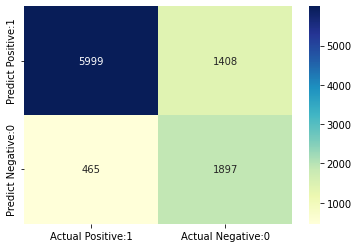

In [45]:
# Visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
# Classification metrices

# Classification Report
# Classification report is another way to evaluate the classification model performance. It displays the precision, recall, f1 and support scores for the model. I have described these terms in later.